In [1]:
import numpy as np
from astropy.io import fits
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directory of input
# Files are downloaded using the script https://github.com/LSSTDESC/star-challenge/blob/main/precursor-data/hscy3/download_srcfiles.py
dir_input = '/pscratch/sd/y/yomori/hsc/00814/HSC-Y/output/'


In [44]:
# Open all the small fits files and merge into one file 
tra  = []
tdec = []
tx   = []
ty   = []

for f in tqdm(glob(d+'*')):
    f=fits.open(f)
    tra  += list(f[1].data['coord_ra'])
    tdec += list(f[1].data['coord_dec'])
    tx   += list(f[1].data['base_FPPosition_x'])
    ty   += list(f[1].data['base_FPPosition_y'])

ra  = np.asarray(tra)
dec = np.asarray(tdec)
x   = np.asarray(tx)
y   = np.asarray(ty)

np.savez(dir_input+'coords_ra_ccdxy.npz',ra=ra,dec=dec,fpx=x,fpy=y)

100%|██████████| 5459/5459 [02:55<00:00, 31.05it/s]


In [12]:
# Load file saved above
d   = np.load(dir_input+'coords_ra_ccdxy.npz')
ra  = d['ra']
dec = d['dec']
fpx = d['fpx']
fpy = d['fpy']

# Load HSC-Y3 PSF star catalog
import h5py
with h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/star/catalog/txpipe_allfield_star_nosnrcut.h5', "r") as f:
    sra      = f['stars']['ra'][:]
    sdec     = f['stars']['dec'][:]
    se1_mod  = f['stars']['model_e1'][:]
    se2_mod  = f['stars']['model_e2'][:]
    sT_mod   = f['stars']['model_T'][:]
    se1_meas = f['stars']['measured_e1'][:]
    se2_meas = f['stars']['measured_e2'][:]
    sT_meas  = f['stars']['measured_T'][:]
    

In [13]:
# Run cross matching using utilities in astropy
import astropy.units as u
from astropy.coordinates import SkyCoord

# Source file coordinates (saved in radians)
c       = SkyCoord(ra=ra*57.2958*u.degree, dec=dec*57.2958*u.degree)

# Star catalog coordinates  
catalog = SkyCoord(ra=sra*u.degree, dec=sdec*u.degree)

# Set matching criteria to 1 arcsec
max_sep         = 1.0 * u.arcsec
idx, d2d, d3d   = c.match_to_catalog_3d(catalog)
sep_constraint  = d2d < max_sep
c_matches       = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]


In [14]:
xmatch         = fpx[sep_constraint]
ymatch         = fpy[sep_constraint]

ra_match       = ra[idx[sep_constraint]]
dec_match      = dec[idx[sep_constraint]]

se1_mod_match  = se1_mod[idx[sep_constraint]]
se2_mod_match  = se2_mod[idx[sep_constraint]]
sT_mod_match   = sT_mod[idx[sep_constraint]]
se1_meas_match = se1_meas[idx[sep_constraint]]
se2_meas_match = se2_meas[idx[sep_constraint]]
sT_meas_match  = sT_meas[idx[sep_constraint]]


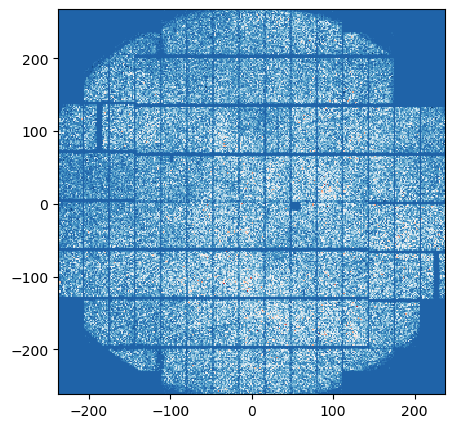

In [19]:
plt.figure(figsize=(5,5))
plt.hist2d(xmatch,ymatch,bins=(300,300),weights=se1_mod_match,cmap='RdBu');
